## Paso 1: Descargar las librerías necesarias

In [583]:
import json
from typing import NamedTuple
from datetime import datetime
import google.cloud.aiplatform as aiplatform
from google.cloud.aiplatform import pipeline_jobs

from kfp.v2 import dsl, compiler

from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Output,
                        Model,
                        Metrics,
                        component, 
                        OutputPath, 
                        InputPath )
import matplotlib.pyplot as plt
import numpy as np

 #### Definir versiones de Paquetes 

In [441]:
PANDAS = "pandas==1.3.2"
SKLEARN = "scikit-learn==1.0.2"
TENSORFLOW = "tensorflow==2.11.0"
GCLOUD_AIR = "google.cloud.aiplatform==1.33.0"
KFP = "kfp==2.4.0"

## Paso 2: Definir Variables del Proyecto

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

#PROJECT_ID = 'psyched-summer-380116'#you have to fill in your project id 
PROJECT_ID = 'aivertexproject-405921'
LOCATION = 'us-central1'#you have to fill in the location of the data
#PIPELINE_ROOT = 'gs://locale_root'#the location where the pipeline's artifacts are stored
BUCKET_NAME="gs://" + "pipelines-tests"
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"

#SERVICE_ACCOUNT = 'sa-vertex-example-oliver@psyched-summer-380116.iam.gserviceaccount.com'#the service account to connect with your project
SERVICE_ACCOUNT = 'glvertex-600@aivertexproject-405921.iam.gserviceaccount.com'
PIPELINE_NAME = "flujo_clasificacion"
JOBID = f"training-pipeline-{TIMESTAMP}"
ENABLE_CACHING = False
TEMPLATE_PATH = "flujo_clasificacion.json"

In [4]:
BASE_IMAGE = "gcr.io/deeplearning-platform-release/xgboost-cpu"

## Paso 3: Definir Componentes

### Componente de Ingesta de Data

In [314]:
@component(
    base_image = BASE_IMAGE, packages_to_install = [TENSORFLOW, SKLEARN, PANDAS],
    output_component_file = "getting_data.yaml"
)

#def get_fmnist_data(dataset_out: Output[Dataset]): 
def get_fmnist_data(
     dataset_train: OutputPath(),
     dataset_test: OutputPath()):
    
    import pandas as pd
    import tensorflow as tf
    from tensorflow.keras.datasets import fashion_mnist
    import os
    import pickle
    #dataset_fmnist = fashion_mnist.load_data()
    #dataset_out = dataset_fmnist.to_csv(dataset_out.path, index=False)  
    #dataset = fashion_mnist.load_data()
    
    train , test = fashion_mnist.load_data()
    
    with open(dataset_train + ".pkl", 'wb') as file:
                pickle.dump(train, file)
    
    with open(dataset_test + ".pkl", 'wb') as file:
               pickle.dump(test, file)

    #return dataset_out

/var/tmp/ipykernel_3231/248007256.py:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(
/var/tmp/ipykernel_3231/248007256.py:7: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  def get_fmnist_data(


### Componente de Entrenamiento del Modelo

In [598]:
@component(
        base_image = "gcr.io/deeplearning-platform-release/tf-gpu.2-11.py310", 
        packages_to_install = [TENSORFLOW],
        output_component_file="model_training.yaml"
)

def model_training(
    dataset_train: InputPath(),
    dataset_test: InputPath(),
    model: Output[Model])-> NamedTuple(
    "Outputs",
    [
        ("train_acc", float),  # Return parameters
        ("train_loss", float)
    ],
):
        import tensorflow as tf
        from tensorflow.keras import layers, models
        import os
        import pickle
        import joblib


        with open(dataset_train + ".pkl", 'rb') as file:
            train_data = pickle.load(file)

        with open(dataset_test + ".pkl", 'rb') as file:
            test_data = pickle.load(file)   


        (train_images, train_labels) = train_data
        (test_images, test_labels) = test_data

        train_images, test_images = train_images / 255.0, test_images / 255.0

        fmodel = models.Sequential()

        # Convolutional and Pooling Layers
        fmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
        fmodel.add(layers.MaxPooling2D((2, 2)))
        fmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
        fmodel.add(layers.MaxPooling2D((2, 2)))

         # Flatten the output for the fully connected layers
        fmodel.add(layers.Flatten())

        # Fully Connected Layers
        fmodel.add(layers.Dense(64, activation='relu'))
        fmodel.add(layers.Dense(10, activation='softmax'))  # 10 output classes for MNIST digits

        # Compile the model
        fmodel.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


        history = fmodel.fit(train_images, train_labels,
                                    batch_size=32,
                                    epochs=5,
                                    validation_data=(test_images, test_labels),
                                    shuffle=True)

        #model.metadata["framework"] = "xgboost" 
        # Save the model as an artifact
        #with open(model.path, 'wb') as f: 
         #   pickle.dump({
        #        "pipeline": fmodel.model_pipeline,
         #       "target": fmodel.target,
        #        "scores_dict": fmodel.scores}, f)
        # ensure to change GCS to local mount path
        
        
        os.makedirs(model.path, exist_ok=True)
        
        fmodel.save( model.path + '/fmnist.h5')
        
        tf.saved_model.save(fmodel, model.path)
        #model.save('./model/keras_model.h5')

        #joblib.dump(fmodel, model.path + "/model.joblib")
        
        may_acurr = 0
        cont = 0
        cont_temp = 0
        for ele in history.history['accuracy']:
            if (ele > may_acurr):
                may_acurr = ele
                cont_temp = cont
            cont += 1

        loss = history.history['loss'][cont_temp]
        
        
        return (may_acurr, loss);
    

/var/tmp/ipykernel_3231/894580935.py:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(
/var/tmp/ipykernel_3231/894580935.py:7: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  def model_training(


### Componente de Evaluación del Modelo

In [530]:
@component(
       base_image = BASE_IMAGE, packages_to_install = [TENSORFLOW, PANDAS],
        output_component_file="model_evaluation.yaml" )
def evaluate_model(
    dataset_test: InputPath(),
    model: Input[Model],
    metrics_train: Output[Metrics],
    metrics_test: Output[Metrics],
    train_acc: float,
    train_loss: float
):
    import tensorflow as tf
    from tensorflow.keras import layers, models
    from keras.models import load_model
    import pickle 
    import os
    #import joblib
    
    #model_path = os.path.join(model.path, "model.joblib")
    #model = joblib.load(model_path)
    
    model_path = os.path.join(model.path, "fmnist.h5")
   # model = tf.saved_model.load(model.path)
    model = tf.keras.models.load_model(model_path)
    
    with open(dataset_test + ".pkl", 'rb') as file:
            test_data = pickle.load(file)   

    (test_images, test_labels) = test_data
    test_images = test_images / 255.0
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    
    metrics_train.log_metric("Train Accuracy" , train_acc)
    metrics_train.log_metric("Train Loss" , train_loss)
    
    metrics_test.log_metric("Test Accuracy" , test_acc)
    metrics_test.log_metric("Test Loss" , test_loss)


/var/tmp/ipykernel_3231/1816590585.py:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(
/var/tmp/ipykernel_3231/1816590585.py:4: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  def evaluate_model(


In [286]:
import google.cloud.aiplatform as vertex_ai
from pathlib import Path as pt

#print(aiplatform)
print(vertex_ai)

<module 'google.cloud.aiplatform' from '/opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform/__init__.py'>


## Paso 5: Desplegar Modelo

In [554]:
@component(
    base_image=BASE_IMAGE, packages_to_install = [GCLOUD_AIR, KFP], 
    install_kfp_package=True,
    output_component_file="model_deployment.yaml",
)
def deploy_fmnist(
        serving_container_image_uri: str,
        display_name: str,
        model_endpoint: str,
        gcp_project: str,
        gcp_region: str,
        model: Input[Model],
        vertex_model: Output[Model],
        vertex_endpoint: Output[Model]
):

    import google.cloud.aiplatform as vertex_ai

    from kfp.v2 import dsl, compiler
    from pathlib import Path
    import os
    
    model_xpath = os.path.join(model.path, "saved_model.pb")
    
    
    # Checks existing Vertex AI Enpoint or creates Endpoint if it is not exist.
    def create_endpoint ():
        endpoints = vertex_ai.Endpoint.list(
        filter='display_name="{0}"'.format(model_endpoint),
        order_by='create_time desc',
        project=gcp_project,
        location=gcp_region,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0] # most recently created
        else:
            endpoint = vertex_ai.Endpoint.create(
                display_name=model_endpoint,
                project=gcp_project,
                location=gcp_region
        )
        return endpoint

    endpoint = create_endpoint()
    
    def upload_model():
        listed_model = vertex_ai.Model.list(
        filter='display_name="{0}"'.format(display_name),
        project=gcp_project,
        location=gcp_region,
        )
        if len(listed_model) > 0:
            model_version = listed_model[0] # most recently created
            model_upload = vertex_ai.Model.upload(
                    display_name=display_name,
                    #parent_model=model_version.resource_name,
                    #artifact_uri=artifact_uri,
                    #artifact_uri=str(Path(model.path).parent),
                    artifact_uri=str(model.path),
                    serving_container_image_uri=serving_container_image_uri,
                    location=gcp_region
            )
        else:
            model_upload = vertex_ai.Model.upload(
                    display_name=display_name,
                    #artifact_uri=str(Path(model.path).parent),
                    artifact_uri=str(model.path),
                    serving_container_image_uri=serving_container_image_uri,
                    location=gcp_region,
            )
        return model_upload
    
    uploaded_model = upload_model()
    
    # Save data to the output params
    vertex_model.uri = uploaded_model.resource_name

    # Deploys trained model to Vertex AI Endpoint
    model_deploy = uploaded_model.deploy(
        machine_type='n1-standard-4',
        endpoint=endpoint,
        min_replica_count=1,
        max_replica_count=1,
        traffic_split={"0": 100},
        deployed_model_display_name=display_name,
    )

    # Save data to the output params
    vertex_endpoint.uri = model_deploy.resource_name

/var/tmp/ipykernel_3231/2058222123.py:1: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  @component(
/var/tmp/ipykernel_3231/2058222123.py:6: DeprecationWarning: output_component_file parameter is deprecated and will eventually be removed. Please use `Compiler().compile()` to compile a component instead.
  def deploy_fmnist(


## Paso 6: Crear el Pipeline

In [558]:
# USE TIMESTAMP TO DEFINE UNIQUE PIPELINE NAMES
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
JOBID = 'fmnist-job{0}'.format(TIMESTAMP)
#JOBID = f"training-pipeline-{TIMESTAMP}"
print(JOBID)

fmnist-job20231125174807


In [559]:
@dsl.pipeline(
    name="flujo_fmnist",
    pipeline_root=PIPELINE_ROOT
    # A name for the pipeline. Use to determine the pipeline Context.
)

def pipeline(
    project: str = PROJECT_ID,
    region: str = LOCATION, 
    #display_name: str = JOBID,    
    serving_container_image_uri: str = 'gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-5:latest'
):

    dataop = get_fmnist_data().set_display_name("Ingest Data")
    #data_preprocess_op = preprocess_houseprice_data(data_op.outputs["dataset_train"])
    #train_text_split_data = train_text_split(dataset_in=dataop.outputs["dataset_out"])
    train_model_op = model_training(dataset_train=dataop.outputs["dataset_train"], dataset_test=dataop.outputs["dataset_test"]).set_display_name("Train Model")
    #train_model_op = model_training()
    model_evaluation_op = evaluate_model(dataset_test=dataop.outputs["dataset_test"],
                                         model = train_model_op.outputs["model"] ,
                                         train_acc = train_model_op.outputs["train_acc"], 
                                         train_loss = train_model_op.outputs["train_loss"],
                                        ).set_display_name("Evaluate Model")
    
    ## condicional para el depliegue
    #dsl.conditional()
    
    deploy_model_op = deploy_fmnist(
        model = train_model_op.outputs['model'],
        gcp_project = project,
        gcp_region = region, 
        serving_container_image_uri = serving_container_image_uri,
        display_name = "fashion_mnist",
        model_endpoint = "fmnist_endpoint"
    )

## Paso 7: Compilar el Pipeline

In [560]:
# COMPILE THE PIPELINE (to create the job spec file)

compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='ml_fmnist.json')

In [230]:
#aiplatform.init(project=PROJECT_ID, location=LOCATION)

In [561]:
# CREATE A RUN USING THE JOB SPEC FILE GENERATED 

start_pipeline = aiplatform.pipeline_jobs.PipelineJob(
    display_name=PIPELINE_NAME,
    template_path="ml_fmnist.json",
    enable_caching=False,
    location=LOCATION,
    job_id = JOBID
)



In [562]:
import os
PIPELINE_SERVICE_ACCOUNT = os.getenv("PIPELINE_SERVICE_ACCOUNT", SERVICE_ACCOUNT) 
print(PIPELINE_SERVICE_ACCOUNT)

glvertex-600@aivertexproject-405921.iam.gserviceaccount.com


In [563]:
start_pipeline.submit(service_account=PIPELINE_SERVICE_ACCOUNT)

Creating PipelineJob
PipelineJob created. Resource name: projects/251922093489/locations/us-central1/pipelineJobs/fmnist-job20231125174807
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/251922093489/locations/us-central1/pipelineJobs/fmnist-job20231125174807')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/fmnist-job20231125174807?project=251922093489


In [ ]:
#start_pipeline.submit(service_account=SERVICE_ACCOUNT)

### Probar y obtener Predicciones del Modelo mediante el uso del Endpoint

In [566]:
# Obtener Data de Prueba
from tensorflow.keras.datasets import fashion_mnist

    #dataset_fmnist = fashion_mnist.load_data()
    #dataset_out = dataset_fmnist.to_csv(dataset_out.path, index=False)  
    #dataset = fashion_mnist.load_data()
    
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()



In [568]:
#endpoint_name = f"projects/{PROJECT_NUMBER}/locations/us-central1/endpoints/{ENDPOINT_ID}"
endpoint_name = f"projects/251922093489/locations/us-central1/endpoints/4629966498750791680"

endpoint = aiplatform.Endpoint(endpoint_name = endpoint_name)
                               

In [652]:
# Data de prueba contiene 10000 valores
valor = 35 #Valor editable como máxima posición 10000

X_test = test_images[valor].reshape(28, 28, 1)
X_test = X_test.tolist()


In [592]:
#import matplotlib as plt 
#import numpy as np
def mostrar_imagen(i):
    plt.figure(figsize=(4,4))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
    plt.show()

# assign each numerical label to its English equivalent
#class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
class_names = ['Camiseta/top','Pantalones','Jersey','Vestido','Abrigo','Sandalias','Camisa','Zapatillas','Bolso','Botines']

def clasificar(num):  
    print('La predicción del modelo fue: '+ str(class_names[num]))

def result(val):
    print("\nLa categoría real es: "+ str(class_names[test_labels[val]]))
    
    


### Generar las Predicciones

In [653]:
predictions = endpoint.predict(instances=[X_test]).predictions

print("Predicciones: ")
print("")
print(predictions)


Predicciones: 

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


### Mostrar Predicciones

La predicción del modelo fue: Camiseta/top

La categoría real es: Camiseta/top


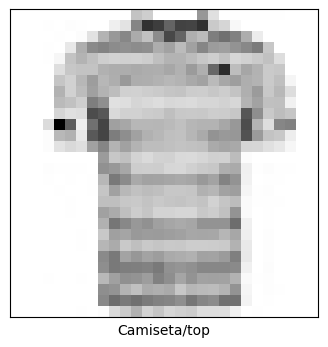

In [654]:
pred = np.argmax(predictions)
clasificar(pred)
result(valor)
mostrar_imagen(valor)
